# Preprocessing


In [0]:
from numpy import array, argmax, random, take
import pandas as pd
from google.colab import drive
import os

import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding,RepeatVector, TimeDistributed,GRU
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model,Model
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import string
import numpy as np
import time
from nltk.translate.bleu_score import corpus_bleu

Using TensorFlow backend.


In [0]:
drive.mount('/content/gdrive')
root_path = "/content/gdrive/My Drive/Machine Learning/"

#Load dataset
def load_data(path):
    input_file = os.path.join(root_path, path)
    with open(input_file, "r",encoding="utf8") as f:
        data = f.read()
    f.close()

    return data.strip().split('\n')
en_data = load_data('news-commentary-v8.de-en.en')
de_data = load_data('news-commentary-v8.de-en.de')
en_sentences = en_data[:1500]
de_sentences = de_data[:1500]

#clean data
def clean_data(strs):
  strs = (strs.translate(str.maketrans('', '', string.punctuation))).lower()
  return strs.strip()

for i in range(len(en_sentences)):
  en_sentences[i] = clean_data(en_sentences[i])
  de_sentences[i] = clean_data(de_sentences[i])
  
#split data
en_train, en_test, de_train, de_test = train_test_split(en_sentences,de_sentences, test_size=0.03, random_state=12)

print(en_data[0])
print(de_data[0])
print("\nClean data:")
print(en_sentences[0])
print(de_sentences[0])

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
SAN FRANCISCO – It has never been easy to have a rational conversation about the value of gold.
SAN FRANCISCO – Es war noch nie leicht, ein rationales Gespräch über den Wert von Gold zu führen.

Clean data:
san francisco – it has never been easy to have a rational conversation about the value of gold
san francisco – es war noch nie leicht ein rationales gespräch über den wert von gold zu führen


In [0]:
def tokenization(sentence):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentence)
    return tokenizer.texts_to_sequences(sentence), tokenizer
  
def pad(x, length=None):
    return pad_sequences(x, maxlen=length, padding='post')
  
def preprocess(x, y):
    """
    Preprocess x and y
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = tokenization(x)
    preprocess_y, y_tk = tokenization(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

In [0]:
#Tokenization

# en_tokenizer, en_tokenized= tokenization(en_sentences)
# de_tokenizer, de_tokenized= tokenization(de_sentences)

# max_en = max([len(line) for line in en_tokenized])
# max_de=max([len(line) for line in de_tokenized])
# en_vocab_size = len(en_tokenizer.word_index)+1
# de_vocab_size = len(de_tokenizer.word_index)+1

preproc_de, preproc_en, de_tokenizer, en_tokenizer =\
    preprocess(de_sentences, en_sentences)

max_en = preproc_en.shape[1]
max_de = preproc_de.shape[1]
en_vocab_size = len(en_tokenizer.word_index)+1
de_vocab_size = len(de_tokenizer.word_index)+1
 

print('Data Preprocessed')
print('Number of sentences: {}'.format(len([sentence for sentence in en_sentences])))
print('Max English sentence length: {}'.format(max_en))
print('Max Deutsch sentence length: {}'.format(max_de))
print('English vocabulary size : {}'.format(en_vocab_size))
print('Deutch Vocabulary Size : {}'.format(de_vocab_size))

Data Preprocessed
Number of sentences: 1500
Max English sentence length: 93
Max Deutsch sentence length: 89
English vocabulary size : 6299
Deutch Vocabulary Size : 8435


In [0]:
#Encode
def encode_sequences(tokenizer, lines,length):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq
leng_de_en = min(max_en,max_de)
trainX = encode_sequences(de_tokenizer, de_train, leng_de_en)
trainY = encode_sequences(en_tokenizer, en_train, leng_de_en)
testX = encode_sequences(de_tokenizer, de_test, leng_de_en)
testY = encode_sequences(en_tokenizer, en_test, leng_de_en)

# LSTM

*   Untuk encoder akan menggunakan embedding dan LSTM layer
*   Untuk decoder, menggunakan LSTM layer lainnya dan dense layer

Input > Embedding > Encoder > Decoder > Dense > Output

In [0]:
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    rms = optimizers.RMSprop(lr=0.001)
    model.compile(optimizer=rms, loss='sparse_categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

In [0]:
#counting time per epoch
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()
    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
        
filename = 'usingLSTM'
model = build_model(de_vocab_size, en_vocab_size, leng_de_en,leng_de_en, 256)
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
time_history= TimeHistory()
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=25, batch_size=256, 
          validation_split = 0.2,
          callbacks=[checkpoint,time_history], verbose=1)

W0622 11:39:23.069265 140295467124608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0622 11:39:23.091842 140295467124608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0622 11:39:23.095300 140295467124608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0622 11:39:23.422114 140295467124608 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2974: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instruct

Train on 1164 samples, validate on 291 samples
Epoch 1/25
1164/1164 [==============================] - 70s 60ms/step - loss: 7.2942 - categorical_accuracy: 0.7801 - val_loss: 2.9271 - val_categorical_accuracy: 1.0000

Epoch 00001: val_loss improved from inf to 2.92712, saving model to usingLSTM
Epoch 2/25
1164/1164 [==============================] - 66s 57ms/step - loss: 2.4839 - categorical_accuracy: 1.0000 - val_loss: 2.3943 - val_categorical_accuracy: 1.0000

Epoch 00002: val_loss improved from 2.92712 to 2.39425, saving model to usingLSTM
Epoch 3/25
1164/1164 [==============================] - 68s 58ms/step - loss: 2.2799 - categorical_accuracy: 1.0000 - val_loss: 2.3683 - val_categorical_accuracy: 1.0000

Epoch 00003: val_loss improved from 2.39425 to 2.36832, saving model to usingLSTM
Epoch 4/25
1164/1164 [==============================] - 66s 57ms/step - loss: 2.2361 - categorical_accuracy: 1.0000 - val_loss: 2.3670 - val_categorical_accuracy: 1.0000

Epoch 00004: val_loss impro

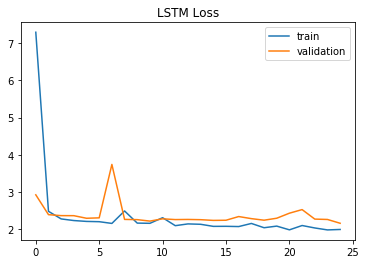

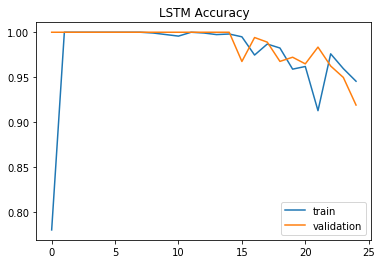

In [0]:
plt.title('LSTM Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

plt.title('LSTM Accuracy')
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['train','validation'])
plt.show()

In [0]:
sum_lstm=0
for i in history.history['val_loss']:
  sum_lstm= sum_lstm + i
print(sum_lstm)
print(sum_lstm/25)

59.55154003883965
2.382061601553586


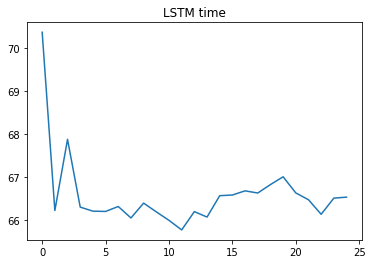

In [0]:
plt.title('LSTM time')
plt.plot(time_history.times)
plt.show()

# GRU

In [0]:
def encdec_model(de_vocab_size,en_vocab_size, output_sequence_length,units):
  
    learning_rate = 0.001
    model = Sequential()
    model.add(Embedding(de_vocab_size, units, input_length=output_sequence_length,mask_zero=True))
    model.add(GRU(units,return_sequences = False))
    model.add(RepeatVector(output_sequence_length))
    model.add(GRU(units, return_sequences = True))
    model.add(TimeDistributed(Dense(en_vocab_size, activation="softmax")))
    rms = optimizers.RMSprop(learning_rate)
    model.compile(optimizer=rms, loss='sparse_categorical_crossentropy',metrics=['categorical_accuracy'])
    return model

In [0]:
filename = 'usingGRU'
model_gru = encdec_model(de_vocab_size, en_vocab_size, leng_de_en,256)
#print(model_gru.summary())
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
time_history2= TimeHistory()
history2 = model_gru.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=25, batch_size=256, 
          validation_split = 0.2,
          callbacks=[checkpoint,time_history2], verbose=1)

Train on 1164 samples, validate on 291 samples
Epoch 1/25
1164/1164 [==============================] - 56s 48ms/step - loss: 7.3930 - categorical_accuracy: 0.7809 - val_loss: 2.7426 - val_categorical_accuracy: 1.0000

Epoch 00001: val_loss improved from inf to 2.74255, saving model to usingGRU
Epoch 2/25
1164/1164 [==============================] - 54s 47ms/step - loss: 2.4143 - categorical_accuracy: 1.0000 - val_loss: 2.3438 - val_categorical_accuracy: 1.0000

Epoch 00002: val_loss improved from 2.74255 to 2.34378, saving model to usingGRU
Epoch 3/25
1164/1164 [==============================] - 54s 47ms/step - loss: 2.2148 - categorical_accuracy: 1.0000 - val_loss: 2.3129 - val_categorical_accuracy: 1.0000

Epoch 00003: val_loss improved from 2.34378 to 2.31286, saving model to usingGRU
Epoch 4/25
1164/1164 [==============================] - 55s 47ms/step - loss: 2.2069 - categorical_accuracy: 1.0000 - val_loss: 2.2925 - val_categorical_accuracy: 1.0000

Epoch 00004: val_loss improved

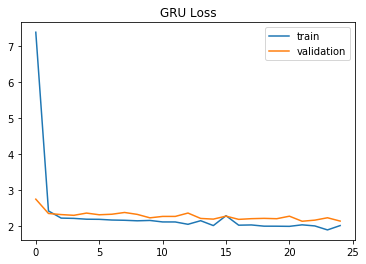

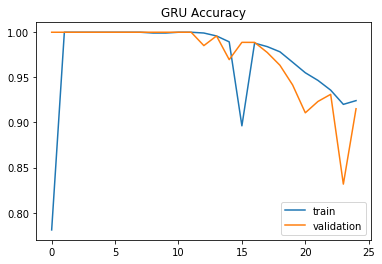

In [0]:
plt.title('GRU Loss')
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

plt.title('GRU Accuracy')
plt.plot(history2.history['categorical_accuracy'])
plt.plot(history2.history['val_categorical_accuracy'])
plt.legend(['train','validation'])
plt.show()

In [0]:
#rata - rata error
sum_gru=0
for i in history2.history['val_loss']:
  sum_gru= sum_gru + i
print(sum_gru)
print(sum_gru/25)

56.820934796251365
2.2728373918500546


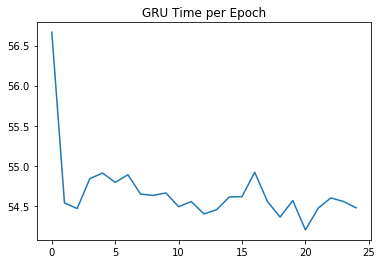

In [0]:
plt.title('GRU Time per Epoch')
plt.plot(time_history2.times)
plt.show()

#Time training dan Bleu Score

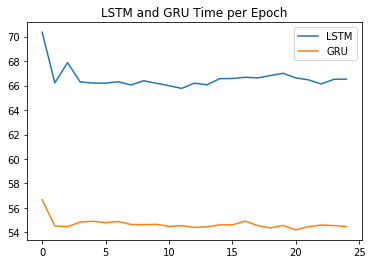

In [0]:
plt.title('LSTM and GRU Time per Epoch')
plt.plot(time_history.times)
plt.plot(time_history2.times)
plt.legend(['LSTM','GRU'])
plt.show()

## Evaluasi

Digunakan untuk evaluasi model

### LSTM

In [0]:
model = load_model('usingLSTM') 

preds = model.predict_classes(testX.reshape((testX.shape[0], testX.shape[1])))
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None
preds_text = [] 
for i in preds:        
       temp = []        
       for j in range(len(i)):             
            t = word_for_id(i[j], en_tokenizer)             
            if j > 0:                 
                if (t==word_for_id(i[j-1],en_tokenizer))or(t== None):                       
                     temp.append('')                 
                else:                      
                     temp.append(t)             
            else:                    
                if(t == None):                                   
                     temp.append('')                    
                else:                           
                     temp.append(t)        
       preds_text.append(' '.join(temp))

In [0]:
pred_df = pd.DataFrame({'actual' : en_test[:], 'predicted' : 
                        preds_text})
pred_df

,actual,predicted
0,but the research is advancing fast and it is a...,the ...
1,but then technology demographics and globaliza...,the ...
2,5160160160160160 a new cap should include a po...,the ...
3,under putin the security service has had its r...,the ...
4,european union leaders now recognize this kick...,the ...
5,turkey has become an invaluable asset in the m...,the ...
6,plenty of evidence suggests that we are in som...,the ...
7,and many die simply because there are no cures...,the ...
8,the terrorist bombings in madrid and london an...,the ...
9,now that gold has crossed the magic 1000 barri...,the ...


### GRU

In [0]:
model = load_model('usingGRU') 

preds2 = model.predict_classes(testX.reshape((testX.shape[0], testX.shape[1])))
preds_text2 = [] 
for i in preds2:        
       temp = []        
       for j in range(len(i)):             
            t = word_for_id(i[j], en_tokenizer)             
            if j > 0:                 
                if (t==word_for_id(i[j-1],en_tokenizer))or(t== None):                       
                     temp.append('')                 
                else:                      
                     temp.append(t)             
            else:                    
                if(t == None):                                   
                     temp.append('')                    
                else:                           
                     temp.append(t)        
       preds_text2.append(' '.join(temp))

In [0]:
pred_gru = pd.DataFrame({'actual' : en_test, 'predicted' : 
                        preds_text2})
pred_gru

,actual,predicted
0,but the research is advancing fast and it is a...,the ...
1,but then technology demographics and globaliza...,the ...
2,5160160160160160 a new cap should include a po...,the ...
3,under putin the security service has had its r...,the ...
4,european union leaders now recognize this kick...,the ...
5,turkey has become an invaluable asset in the m...,the ...
6,plenty of evidence suggests that we are in som...,the ...
7,and many die simply because there are no cures...,the ...
8,the terrorist bombings in madrid and london an...,the ...
9,now that gold has crossed the magic 1000 barri...,the ...


# reference

https://medium.com/analytics-vidhya/a-must-read-nlp-tutorial-on-neural-machine-translation-the-technique-powering-google-translate-c5c8d97d7587

https://towardsdatascience.com/neural-machine-translation-with-python-c2f0a34f7dd

https://machinelearningmastery.com/develop-neural-machine-translation-system-keras/

https://stackoverflow.com/questions/43178668/record-the-computation-time-for-each-epoch-in-keras-during-model-fit/43186440